## Apply machine learning models for job posting prediction (fraudulent vs. non-fraudulent). 
### The dataset is imbalanced, so the SMOTE technique will be applied for oversampling.

In [1]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.layers import Dense,Flatten,Dropout
from keras.models import Sequential

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

import nltk
from nltk.corpus import stopwords,wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# EDA

In [3]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [4]:
df.describe(include='object')

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17534,6333,2868,14572,17879,15184,10668,14409,10830,9775,12977,11425
unique,11231,3105,1337,874,1709,14801,11967,6204,5,7,13,131,37
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,718,551,142,726,379,410,726,11620,3809,5145,1734,1749


In [5]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df['title'].value_counts()

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
                                                     ... 
Java Script Developer                                   1
 PeopleSoft HR Functional Lead                          1
CRM Manager (Junior or Senior)                          1
iOS Developer Training                                  1
Senior Operational Manager                              1
Name: count, Length: 11231, dtype: int64

In [7]:
df['required_experience'].value_counts()

required_experience
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: count, dtype: int64

In [8]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

<Axes: xlabel='fraudulent', ylabel='count'>

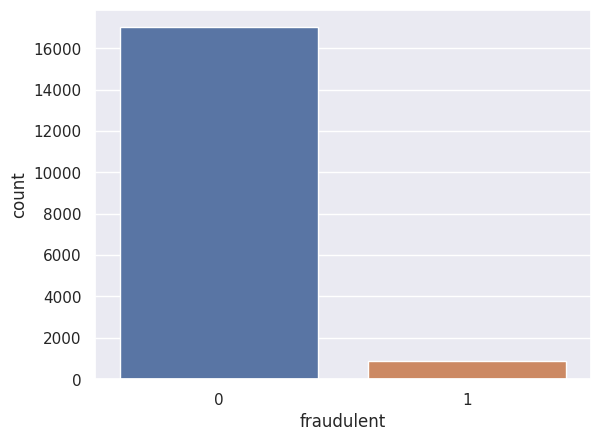

In [65]:
sns.countplot(x='fraudulent',data=df)

In [9]:
del df['job_id']
del df['salary_range']

In [10]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [11]:
df.fillna(" ",inplace=True)
df['text']=df.apply(lambda row: " ".join(row.astype(str)),axis=1)

In [12]:
df['text'][0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [13]:
df=df.drop(
    columns=['title','location','department','company_profile','description',
             'requirements','benefits','employment_type','required_experience',
             'required_education','industry','function'],axis=1)

In [14]:
df

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotS..."
...,...,...,...,...,...
17875,0,1,1,0,"Account Director - Distribution CA, ON, Toron..."
17876,0,1,1,0,"Payroll Accountant US, PA, Philadelphia Accoun..."
17877,0,0,0,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,0,1,0,"Graphic Designer NG, LA, Lagos Nemsia Stud..."


## preprocessing

In [15]:
nltk.download('averaged_perceptron_tagger')  # For POS tagging

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
stop_word=set(stopwords.words('english'))

## get_wordnet_pos() =>
### function used when preprocessing text for tasks like lemmatization, where words need to be reduced to their base forms based on their correct part of speech
### takes a part-of-speech (POS) tag from the Penn Treebank tag set and maps it to a corresponding POS tag used by the WordNet lexical database,  The function ensures that the POS tag is translated into a format compatible with WordNet's system.

In [18]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to Noun

In [17]:
# for char in string.punctuation:
#     print(char,end=" " )
translated_table = str.maketrans('', '', string.punctuation)

In [19]:
def preprocess_txt(txt):
    text = txt.lower()
    # Remove digits
    text = re.sub(r'\d+', "", text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove punctuations
    text = text.translate(translated_table)
    # Tokenize words using word tokenize and remove stop words
    text_tokens = word_tokenize(text)
    filtered_words = [word for word in text_tokens if word not in stop_word]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Lemmatize each word using its POS tag
    lemma_words = []
    for word in filtered_words:
        pos_tag = nltk.pos_tag([word])[0][1]  # Get POS tag for each word
        wordnet_pos = get_wordnet_pos(pos_tag)  # Map POS to WordNet POS
        lemma_word = lemmatizer.lemmatize(word, pos=wordnet_pos)  # Lemmatize using WordNet POS
        lemma_words.append(lemma_word)

    return ' '.join(lemma_words)

### nltk.download() problem
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

In [29]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [30]:
df['text'] = df['text'].apply(preprocess_txt)
print(df.head())

   telecommuting  has_company_logo  has_questions  fraudulent  \
0              0                 1              0           0   
1              0                 1              0           0   
2              0                 1              0           0   
3              0                 1              0           0   
4              0                 1              1           0   

                                                text  
0  marketing intern u ny new york marketing food ...  
1  customer service cloud video production nz auc...  
2  commission machinery assistant cma u ia wever ...  
3  account executive washington dc u dc washingto...  
4  bill review manager u fl fort worth spotsource...  


In [31]:
df['text'][0]

'marketing intern u ny new york marketing food weve create groundbreaking awardwinning cooking site support connect celebrate home cook give everything need one placewe top editorial business engineering team focus use technology find new well way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish wellknown professional like mario batali gwyneth paltrow danny meyer partnership whole food market random housefood name best food website james beard foundation iacp feature new york time npr pando daily techcrunch today showwere locate chelsea new york city food fastgrowing james beard awardwinning online food community crowdsourced curated recipe hub currently interview full parttime unpaid intern work small team editor executive developer new york city headquartersreproducing andor repackaging exist food content number partner site huffington post yahoo buzzfeed various content manag

In [38]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

# tf-idf

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tv=TfidfVectorizer(ngram_range=(1,3),max_features=500)


text_features = tv.fit_transform(df['text']).toarray()


text_features.shape

(17880, 500)

## this dataset is imbalanced 

## try a sampling technique (SMOTE) 

In [55]:
#X=df.drop(["telecommuting","has_company_logo","has_questions","fraudulent"],axis=1)
X=text_features
y=df['fraudulent']

In [56]:
y.value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y,shuffle=True)


print("shape of x_train :",X_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",X_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : (14304, 500)
shape of y_train : (14304,)
shape of x_test : (3576, 500)
shape of y_test : (3576,)


In [58]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the resampled shapes
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

Shape of X_resampled: (27222, 500)
Shape of y_resampled: (27222,)


# Naive Bayes Model

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
# Initialize the MultinomialNB model
model = MultinomialNB()
# Train the model using the resampled data
model.fit(X_resampled, y_resampled)
# Predict on the test set
y_pred = model.predict(X_test)

In [61]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3403
           1       0.19      0.82      0.31       173

    accuracy                           0.82      3576
   macro avg       0.59      0.82      0.60      3576
weighted avg       0.95      0.82      0.87      3576


Confusion Matrix:
[[2798  605]
 [  32  141]]


# Random Forest Model

In [63]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model using the resampled data
rf_model.fit(X_resampled, y_resampled)
y_pred = rf_model.predict(X_test)

In [64]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.66      0.80       173

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576


Confusion Matrix:
[[3402    1]
 [  58  115]]
